# 人工智能工程基础
在之前的 1~8 节中，我初步体验了一下深度神经网络中的两种网络形式：多重感知器和卷积神经网络，并跟着李沐老师通读了一下 Alex 在 12 年发布的 CNN 的论文。
这些学习让我对神经网络有了初步的印象但是对仍有许多细节上、基础上的内容仍然有些模糊，所以接下来就是跟着其他老师，回看一下基础的内容并加深对神经网络的理解。

参考唐一旦老师的视频：[徒手实现最优化算法--人工智能的工程基础](https://www.bilibili.com/video/BV1Ft421K7NH)

In [1]:
!pip install scikit-learn matplotlib torch


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(1024)  # 设定随机数，让代码可以复现

Raw X: tensor([100.0000, 101.0050, 102.0100, 103.0151, 104.0201, 105.0251, 106.0302,
        107.0352, 108.0402, 109.0452, 110.0502, 111.0553, 112.0603, 113.0653,
        114.0704, 115.0754, 116.0804, 117.0854, 118.0905, 119.0955, 120.1005,
        121.1055, 122.1105, 123.1156, 124.1206, 125.1256, 126.1307, 127.1357,
        128.1407, 129.1457, 130.1508, 131.1558, 132.1608, 133.1658, 134.1709,
        135.1759, 136.1809, 137.1859, 138.1909, 139.1960, 140.2010, 141.2060,
        142.2111, 143.2161, 144.2211, 145.2261, 146.2312, 147.2362, 148.2412,
        149.2462, 150.2513, 151.2563, 152.2613, 153.2663, 154.2714, 155.2764,
        156.2814, 157.2864, 158.2915, 159.2965, 160.3015, 161.3065, 162.3116,
        163.3166, 164.3216, 165.3266, 166.3317, 167.3367, 168.3417, 169.3467,
        170.3518, 171.3568, 172.3618, 173.3668, 174.3719, 175.3769, 176.3819,
        177.3869, 178.3920, 179.3970, 180.4020, 181.4070, 182.4121, 183.4171,
        184.4221, 185.4271, 186.4322, 187.4372, 188.4422,

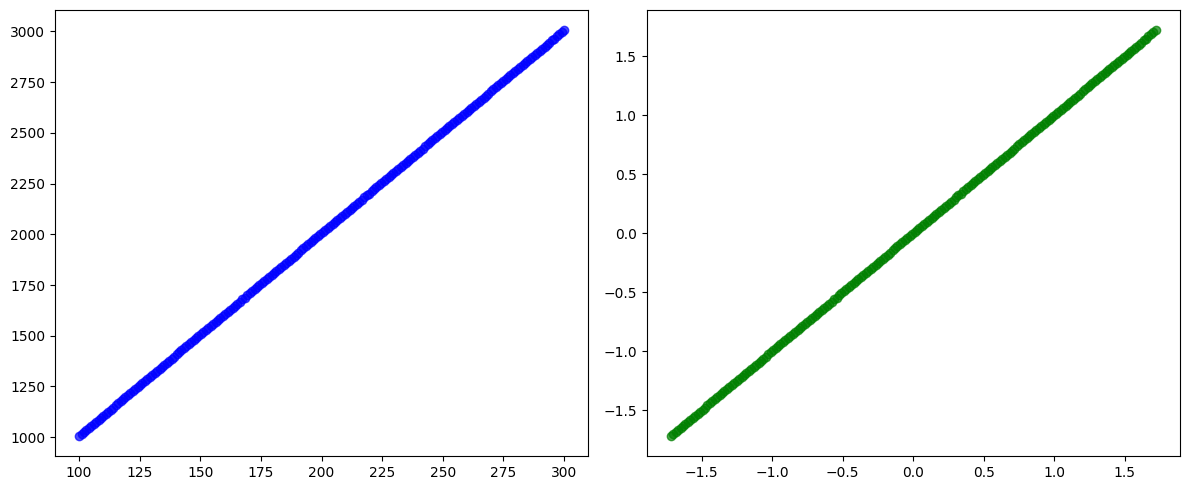

In [4]:
# 这里的处理方法有所不同，视频中的处理方法是对 x 坐标先归一化再加入扰动，这里的处理方法是直接对所有 x y 进行归一化，之后我们会发现归一化之后的拟合值会比较小，这就是归一化的优势。

x_raw = torch.linspace(100, 300, 200)  # 生成 200 个 [100, 300] 区间内的均匀增长一维向量
print("Raw X:", x_raw)
x_normalized = (x_raw - torch.mean(x_raw)) / torch.std(x_raw)  # 归一化处理 x
print("Normalized x:", x_normalized)

epsilon = torch.rand(x_raw.shape)  # 生成随机噪声，作为 y 数据的内容

y_raw = 10 * x_raw + 5 + epsilon  # 原来的 y
y_normalized = (y_raw - torch.mean(y_raw)) / torch.std(y_raw)  # 归一化数据的 y

plt.figure(figsize=(12, 5))

# 子图1：原始数据的分布
plt.subplot(1, 2, 1)
plt.scatter(x_raw.numpy(), y_raw.numpy(), color='blue', alpha=0.7)

# 子图2：归一化后数据的分布
plt.subplot(1, 2, 2)
plt.scatter(x_normalized.numpy(), y_normalized.numpy(), color='green', alpha=0.7)

plt.tight_layout()
plt.show()

# 左图是归一化之前的，右图是归一化之后的，你会发现他把所有点重新映射在了一个更小的区间之中，均值为 0 ，标准差为 1 。

In [5]:
from sklearn import linear_model  # 线性回归模型

In [35]:
m = linear_model.LinearRegression()

# 这里先考虑原始数据
# 因为 scikit-learn 的模型（如 LinearRegression）设计时考虑的是 多变量回归 场景，所以它要求输入的特征 X 必须是 二维数组，这里要把 x_raw.view 一下
m.fit(x_raw.view(-1, 1), y_raw.numpy())
print(m.coef_, m.intercept_)  # 输出的第第一项应该接近 10，第二项应该接近 5，和之前产生的 y 近似

# 这里再考虑归一化之后的数据
m.fit(x_normalized.view(-1, 1), y_normalized.numpy())
print(m.coef_, m.intercept_)  # 输出的第第一项应该接近 1，第二项应该接近 0 （一个很小的数），由于归一化之后拟合的线几乎经过坐标原点

[9.999724] 5.5739746
[0.9999998] 3.8146973e-07


# 损失函数

损失函数是描述估计值与实际值相差的函数，在上面的二元回归问题中，他的损失函数为：

$L(a, b) = \frac{1}{n} \sum_{i=1}^n (y_i - ax_i - b)^2$

其中：

- $a$ 和 $b$ 分别是其斜率和截距
- $y_i$ 是第 $i$ 个样本的实际输出值
- $x_i$ 是第 $i$ 个样本的输入值

这个损失函数叫做 **均方误差（Mean Squared Error, MSE）** ，本质上是将所有点的误差值平方相加求出总体（批量）的损失。

# 泰勒展开

一元函数的泰勒展开：

$f(x) = f(x_k) + (x - x_k)f'(x_k) + \frac{1}{2!}(x - x_k)^2f''(x_k) + o^n$

二元函数的泰勒展开：

$f(x, y) = f(x_k, y_k) + (x - x_k)f_x'(x_k, y_k) + (y - y_k)f_y'(x_k, y_k) + \frac{1}{2!}(x - x_k)^2f_{xx}''(x_k, y_k) + \frac{1}{2!}(x - x_k)(y - y_k)f_{xy}''(x_k, y_k) + \frac{1}{2!}(x - x_k)(y - y_k)f_{yx}''(x_k, y_k) + \frac{1}{2!}(y - y_k)^2f_{yy}''(x_k, y_k) + o^n$

多元函数同理，本质上就是多加了同类型的一项。

# 损失函数的增长量

$\Delta L = L(a_1, b_1) - L(a_0, b_0) (1)$

根据二元的泰勒展开有（需要确保损失函数可微，不过神经网络中大部分函数都是可微的）：

$L(a_1, b_1) = L(a_0, b_0) + (a_1 - a_0)L_a'(a_0, b_0) + (b_1 - b_0)L_b'(a_0, b_0) + o^n (2)$

将 (2) 带入 (1) 有：

$\Delta L \approx (a_1 - a_0)L_a'(a_0, b_0) + (b_1 - b_0)L_b'(a_0, b_0) (3)$

令
$
\begin{cases}
a_1 - a_0 = \Delta a \\
b_1 - b_0 = \Delta b
\end{cases}
$
有：

$\Delta L \approx \Delta aL_a'(a_0, b_0) + \Delta bL_b'(a_0, b_0)$

# 梯度下降

为了使函数值 $L(a,b)$ 减小，我们需要选择 $(\Delta a, \Delta b)$ 的方向，使得 $\Delta L≤0$ 。为此，我们可以利用梯度的方向信息。

梯度 $\nabla L = \left( \frac{\partial L}{\partial a}, \frac{\partial L}{\partial b} \right)$ 是表示函数在某一点上增长最快的方向的量，加个符号就是较少最快的方向的量。

所以我们不妨令 $(\Delta a, \Delta b) = -\eta\nabla L = -\eta\left( \frac{\partial L}{\partial a}, \frac{\partial L}{\partial b} \right) (\eta \geq 0) (4)$

于是把我们的公式 (4) 进一步带入 (3) 可以得到：

$$
\begin{flalign}
\Delta a &= -\eta \frac{\partial L}{\partial a} \\
\Delta b &= -\eta \frac{\partial L}{\partial b} \\
\Delta L &= \frac{\partial L}{\partial a} \cdot (-\eta \frac{\partial L}{\partial a}) + \frac{\partial L}{\partial b} \cdot (-\eta \frac{\partial L}{\partial b}) \\
&= -\eta \left[ \left( \frac{\partial L}{\partial a} \right)^2 + \left( \frac{\partial L}{\partial b} \right)^2 \right]
\end{flalign}
$$

不难看出，公式中的 $-\eta \left[ \left( \frac{\partial L}{\partial a} \right)^2 + \left( \frac{\partial L}{\partial b} \right)^2 \right] \leq 0$，这说明，想要让 $\Delta L$ 下降，让原函数往反梯度方向更新参数能够保证函数值 $L(a,b)$ 不会增加，从而实现优化。

# 优化函数

所以我们的优化函数可以写成：

$a_{k+1} = a_k - \eta \frac{\partial L}{\partial a}, \quad b_{k+1} = b_k - \eta \frac{\partial L}{\partial b}$

# 说明

这一个 Cell 的内容是根据唐一旦老师的 ppt 来撰写的，同时也推荐看一下飞天侠客的视频 [如何计算神经网络的参数](https://www.bilibili.com/video/BV1CVAUeuECE) 同样有讲类似的内容。

需要理解的是：从输入数据到计算估计值（与损失）的这个过程叫做 **正向传播** ，通过损失计算梯度再更新权重的过程叫 **反向传播** 。至于计算损失为什么大括号是因为，在推理时是不计算损失的，计算损失仅存在于训练模型的阶段。

In [58]:
# 手动实现正向传播与反向传播
import torch.nn as nn


class Linear(nn.Module):

    def __init__(self):
        super(Linear, self).__init__()
        # 模型参数定义
        self.a = nn.Parameter(torch.zeros(()))  # torch.zeros(()) 等价于 torch.tensor(0.)，zero 中 () 是一个空的元组，表示维度为空，即 0 维张量。
        self.b = nn.Parameter(torch.zeros(()))

    def forward(self, x):
        # 向前传播
        return self.a * x + self.b

    def string(self):
        return f'y = {self.a.item():.2f} * x + {self.b.item():.2f}'

In [50]:
# 初始化模型与第一次预测
m = Linear()
print(m(x_normalized))
# 展示模型参数
list(m.parameters())

tensor([ 3.4947,  3.4753,  3.4558,  3.4364,  3.4169,  3.3975,  3.3780,  3.3586,
         3.3392,  3.3197,  3.3003,  3.2808,  3.2614,  3.2420,  3.2225,  3.2031,
         3.1836,  3.1642,  3.1447,  3.1253,  3.1059,  3.0864,  3.0670,  3.0475,
         3.0281,  3.0087,  2.9892,  2.9698,  2.9503,  2.9309,  2.9114,  2.8920,
         2.8726,  2.8531,  2.8337,  2.8142,  2.7948,  2.7754,  2.7559,  2.7365,
         2.7170,  2.6976,  2.6781,  2.6587,  2.6393,  2.6198,  2.6004,  2.5809,
         2.5615,  2.5421,  2.5226,  2.5032,  2.4837,  2.4643,  2.4448,  2.4254,
         2.4060,  2.3865,  2.3671,  2.3476,  2.3282,  2.3088,  2.2893,  2.2699,
         2.2504,  2.2310,  2.2116,  2.1921,  2.1727,  2.1532,  2.1338,  2.1143,
         2.0949,  2.0755,  2.0560,  2.0366,  2.0171,  1.9977,  1.9783,  1.9588,
         1.9394,  1.9199,  1.9005,  1.8810,  1.8616,  1.8422,  1.8227,  1.8033,
         1.7838,  1.7644,  1.7450,  1.7255,  1.7061,  1.6866,  1.6672,  1.6477,
         1.6283,  1.6089,  1.5894,  1.57

[Parameter containing:
 tensor(-1.1253, requires_grad=True),
 Parameter containing:
 tensor(1.5603, requires_grad=True)]

In [71]:
import torch.optim as optim

learning_rate = 0.00001  # 就是公式中的 η
model = Linear()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 注意这里用的是没有归一化的数据，拟合了 10 分钟才接近标准答案，因为学习率太小了，如果学习率大一点点会炸，因为更新太快所有参赛都变为了 nan ，
# 而归一化之后的数据就没有这个问题！
for t in range(1000000):
    y_pred = model(x_raw)

    # 定义损失
    loss = (y_raw - y_pred).pow(2).mean()

    # 清空上一步梯度
    optimizer.zero_grad()

    # 计算梯度
    loss.backward()

    # 更新模型参数
    optimizer.step()

print(model.string())


y = 10.01 * x + 4.40


In [72]:
import torch.optim as optim

learning_rate = 0.1  # 就是公式中的 η
model = Linear()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 注意这里用的是没有归一化的数据，拟合了 10 分钟才接近标准答案，因为学习率太小了，如果学习率大一点点会炸，因为更新太快所有参赛都变为了 nan ，
# 而归一化之后的数据就没有这个问题！
for t in range(20):
    y_pred = model(x_normalized)
    # 定义损失
    loss = (y_normalized - y_pred).pow(2).mean()
    # 清空上一步梯度
    optimizer.zero_grad()
    # 计算梯度
    loss.backward()
    # 更新模型参数
    optimizer.step()

print(model.string())


y = 0.99 * x + 0.00


In [77]:
# 手动更新参数

import torch.optim as optim

learning_rate = 0.1  # 就是公式中的 η
model = Linear()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # 优化器的内部公式就是我们最后导出的优化函数的公式

# 注意这里用的是没有归一化的数据，拟合了 10 分钟才接近标准答案，因为学习率太小了，如果学习率大一点点会炸，因为更新太快所有参赛都变为了 nan ，
# 而归一化之后的数据就没有这个问题！
for t in range(20):
    y_pred = model(x_normalized)
    # 定义损失
    loss = (y_normalized - y_pred).pow(2).mean()
    # 清空上一步梯度
    optimizer.zero_grad()  # 优化器自动帮我们清空之前的梯度
    # 计算梯度
    loss.backward()
    # 更新模型参数
    # optimizer.step()
    with torch.no_grad():  # pytorch 默认会记录所有 param 的计算过程并保存到其 grad 中，但是下面的代码是要更新 param 的值，而不是内部图中连续计算得来的，为了不破坏图中的计算，我们需要加上这一句话。
        for param in model.parameters():
            param -= learning_rate * param.grad

print(model.string())


y = 0.99 * x + 0.00


下面是大模型给的梯度下降的局限性，其中里面提到的改进方法，比如加动量，在 AlexNet 中也有提及，此外他的缺点 对噪声敏感 这一点，在我们上述的例子中，假设有一个游离很远的点就会大幅干涉最后的拟合结果，有点像主成成分分析的缺点，详细可以看B站视频了解：[用最直观的方式告诉你：什么是主成分分析PCA](https://www.bilibili.com/video/BV1E5411E71z)

另外，梯度下降算法的计算量也大，每一次迭代都需要计算所有点的数据。

## ⚠️ 梯度下降的六大主要局限

### 1. **学习率难以选择（Learning Rate Sensitivity）**

- ❌ **学习率太大**：参数更新步子太大，可能“跨过”最小值，导致震荡甚至发散（loss 越来越大，变成 `nan`）。
- ❌ **学习率太小**：收敛极慢，需要很多轮迭代才能接近最优解。
- ✅ 理想情况是：开始大学习率快速逼近，后期小步精细调整 —— 但固定学习率做不到。

> 📌 例子：你在非归一化数据上用大学习率，参数爆炸；用小学习率，训练10分钟才收敛。

🔧 **解决方法**：
- 使用**学习率调度器**（Learning Rate Scheduler）
- 改用自适应优化器（如 Adam、RMSProp）

### **卡在鞍点（Saddle Points）**

- 鞍点是某些方向上升、某些方向下降的点，在高维空间非常常见。
- 梯度接近零，导致参数几乎不更新，看起来“收敛”了，其实是卡住了。

> 📌 比如：loss 不再下降，但模型性能很差。

🔧 **解决方法**：
- 使用**动量（Momentum）**：积累历史梯度，帮助突破零梯度区域
- 使用二阶信息或自适应方法（如 Adam）

---

### **各参数更新速度不均衡（Ill-conditioned Problem）**

- 不同参数的梯度尺度差异巨大（比如 `w` 的梯度是 `100`，`b` 的梯度是 `0.01`）
- 用同一个学习率更新，会导致：
  - 大梯度参数震荡
  - 小梯度参数几乎不动

> 📌 你遇到的 `b` 更新极慢就是典型例子！

🔧 **解决方法**：
- **数据归一化**（让输入输出尺度一致）
- **参数归一化**
- 使用**自适应学习率**算法（如 Adagrad、Adam）

---

### **对噪声敏感（尤其 SGD）**

- SGD 使用单个样本或小批量计算梯度，带有随机噪声。
- 好处：可能跳出局部最小
- 坏处：训练过程震荡严重，loss 上下波动，收敛不稳定

> 📌 你可能会看到 loss 曲线像“锯齿”一样上下跳。

🔧 **解决方法**：
- 使用**动量（Momentum）** 平滑更新方向
- 增大 batch size 减少噪声
- 学习率衰减

---

### **收敛速度慢（Slow Convergence）**

- 梯度下降是**一阶优化方法**，只用梯度信息，没有利用曲率（二阶导数）。
- 在“狭长山谷”型损失面中，会出现“之字形”震荡前进，非常低效。

> 📌 想象你在山谷两侧来回撞墙前进，而不是直奔谷底。

🔧 **解决方法**：
- 使用 **Momentum**：像“滚下山坡的球”，积累速度，减少震荡
- 使用 **Nesterov Accelerated Gradient (NAG)**
- 使用二阶方法（如牛顿法，但计算代价高）


In [80]:
### 随机梯度下降算法
# 随机梯度下降算法实际上就是把整个庞大的数据集转化为每个小批次的数据集，然后计算小数据集中的损失，本质上是差不多的
# 这里手动实现批次

import torch.optim as optim

learning_rate = 0.1  # 就是公式中的 η
batch_size = 20
model = Linear()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 注意这里用的是没有归一化的数据，拟合了 10 分钟才接近标准答案，因为学习率太小了，如果学习率大一点点会炸，因为更新太快所有参赛都变为了 nan ，
# 而归一化之后的数据就没有这个问题！
for t in range(20):
    ix = (t * batch_size) % len(x_normalized)
    xx = x_normalized[ix: ix + batch_size]
    yy = y_normalized[ix: ix + batch_size]

    y_pred = model(xx)
    # 定义损失
    loss = (yy - y_pred).pow(2).mean()
    # 清空上一步梯度
    optimizer.zero_grad()
    # 计算梯度
    loss.backward()
    # 更新模型参数
    optimizer.step()

print(model.string())


y = 1.00 * x + 0.01


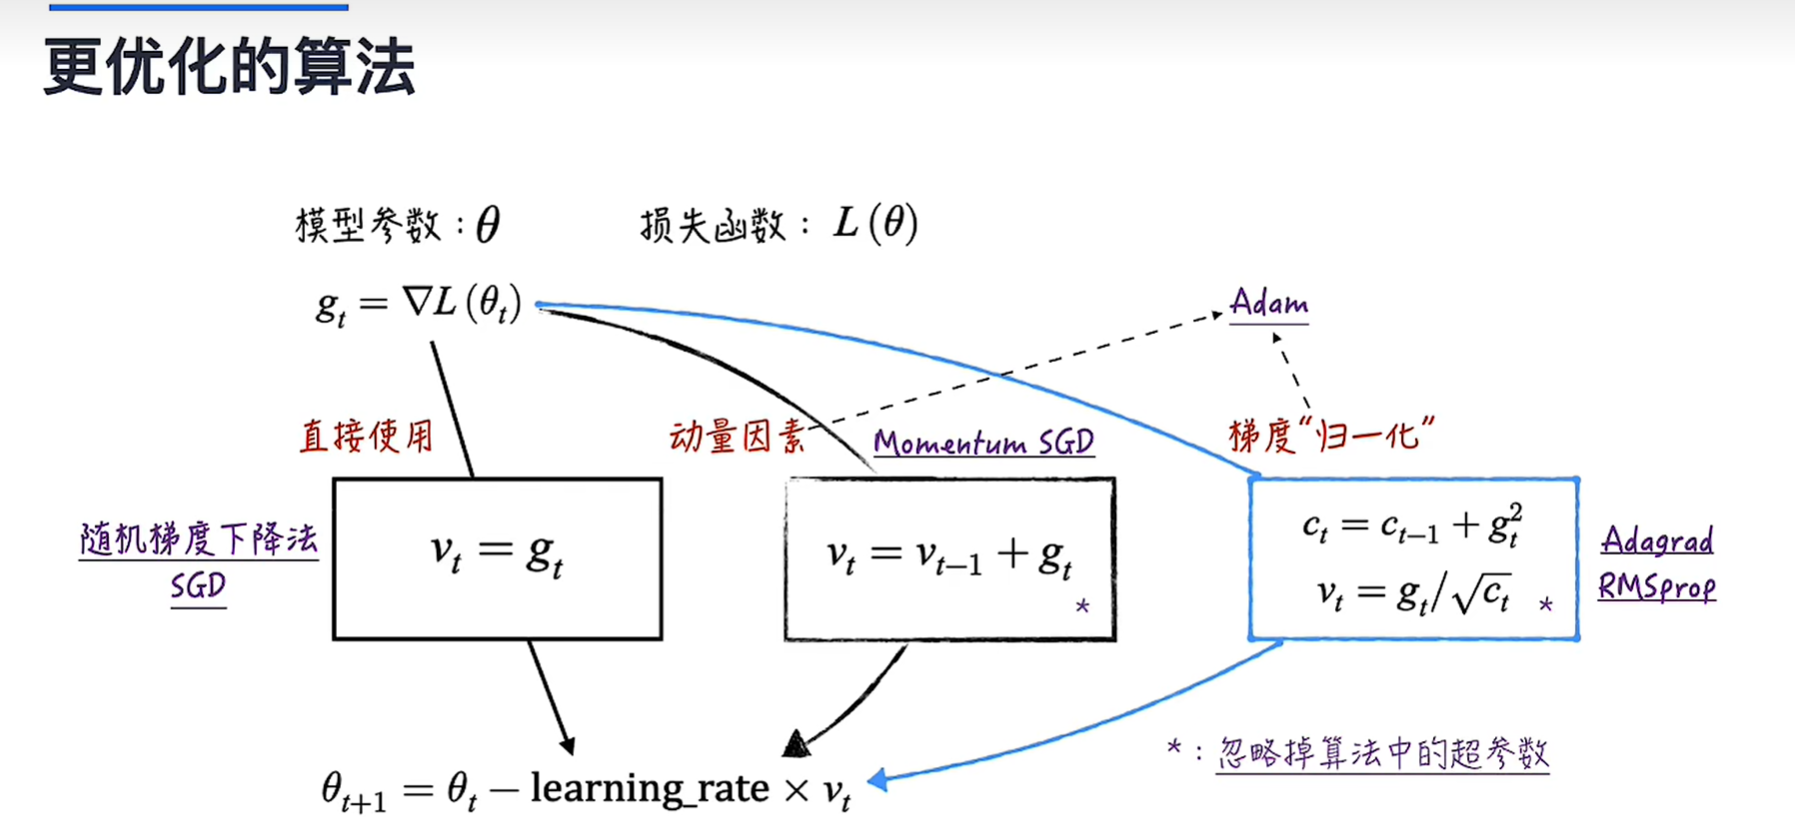

In [81]:
from IPython.display import Image

Image(filename='./images/更优化的优化器.png')

In [87]:
### 换一个优化器

import torch.optim as optim

learning_rate = 0.1  # 就是公式中的 η
batch_size = 20
model = Linear()

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# 注意这里用的是没有归一化的数据，拟合了 10 分钟才接近标准答案，因为学习率太小了，如果学习率大一点点会炸，因为更新太快所有参赛都变为了 nan ，
# 而归一化之后的数据就没有这个问题！
for t in range(20):
    ix = (t * batch_size) % len(x_normalized)
    xx = x_normalized[ix: ix + batch_size]
    yy = y_normalized[ix: ix + batch_size]

    y_pred = model(xx)
    # 定义损失
    loss = (yy - y_pred).pow(2).mean()
    # 清空上一步梯度
    optimizer.zero_grad()
    # 计算梯度
    loss.backward()
    # 更新模型参数
    optimizer.step()

print(model.string())


y = 1.12 * x + -0.05


In [94]:
### 张量的基本操作
a = torch.randn(2, 3, 4)
print(a)
print(a.shape)

# 增加维度
b = a.unsqueeze(0)  # 0 这个参数是 dim，是要插入的维度，0 就是第零维度
print(b)
print(b.shape)

# 降维
c = b.squeeze(0)  # 这个函数用来压缩维度，就是降维，他会把大小为 1 的维度删掉，非 1 删不掉，不加默认把所有为 1 的维度全部删掉
print(c)
print(c.shape)

tensor([[[-1.1072,  0.5233,  0.1083, -0.8777],
         [ 0.6279,  0.0786, -0.9835,  0.4681],
         [-0.6769, -0.8793, -0.5270, -2.2849]],

        [[ 0.0735, -0.2932,  0.8867, -1.8595],
         [-0.7910, -0.6348, -1.0142, -1.5079],
         [ 0.7532,  0.7323, -0.4989, -1.2534]]])
torch.Size([2, 3, 4])
tensor([[[[-1.1072,  0.5233,  0.1083, -0.8777],
          [ 0.6279,  0.0786, -0.9835,  0.4681],
          [-0.6769, -0.8793, -0.5270, -2.2849]],

         [[ 0.0735, -0.2932,  0.8867, -1.8595],
          [-0.7910, -0.6348, -1.0142, -1.5079],
          [ 0.7532,  0.7323, -0.4989, -1.2534]]]])
torch.Size([1, 2, 3, 4])
tensor([[[-1.1072,  0.5233,  0.1083, -0.8777],
         [ 0.6279,  0.0786, -0.9835,  0.4681],
         [-0.6769, -0.8793, -0.5270, -2.2849]],

        [[ 0.0735, -0.2932,  0.8867, -1.8595],
         [-0.7910, -0.6348, -1.0142, -1.5079],
         [ 0.7532,  0.7323, -0.4989, -1.2534]]])
torch.Size([2, 3, 4])


In [123]:
# 改变形状
a = torch.tensor(range(0, 10))
print(a)
print(a.shape)

b = a.view(2, 5)  # 任意为 -1 自动计算如何计算
print(b)
print(b.shape)

c = b.T
print(c)
print(c.shape)

# d = c.view(-1, 10)  # RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.
# 这里报错是因为转置操作会改变数据在内存中的存储位置（从而使得内存不毗邻发生）

# 转而代指可以使用：
print(c.reshape(-1, 10))
# 或者
print(c.contiguous().view(-1, 10))  # 先变连续，再 view

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([10])
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
torch.Size([2, 5])
tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])
torch.Size([5, 2])
tensor([[0, 5, 1, 6, 2, 7, 3, 8, 4, 9]])
tensor([[0, 5, 1, 6, 2, 7, 3, 8, 4, 9]])


In [129]:
### 张量的计算
a = torch.tensor(range(1, 7)).view(2, 3)
b = torch.tensor(range(11, 17)).view(2, 3)

a, b, a * b

(tensor([[1, 2, 3],
         [4, 5, 6]]),
 tensor([[11, 12, 13],
         [14, 15, 16]]),
 tensor([[11, 24, 39],
         [56, 75, 96]]))

In [132]:
### 广播机制
a = torch.tensor(range(1, 7)).view(2, 3)
b = torch.tensor(range(1, 4)).view(3)
a.shape, b.shape, a * b

# 如果验证不通过，计算就会报错

(torch.Size([2, 3]),
 torch.Size([3]),
 tensor([[ 1,  4,  9],
         [ 4, 10, 18]]))

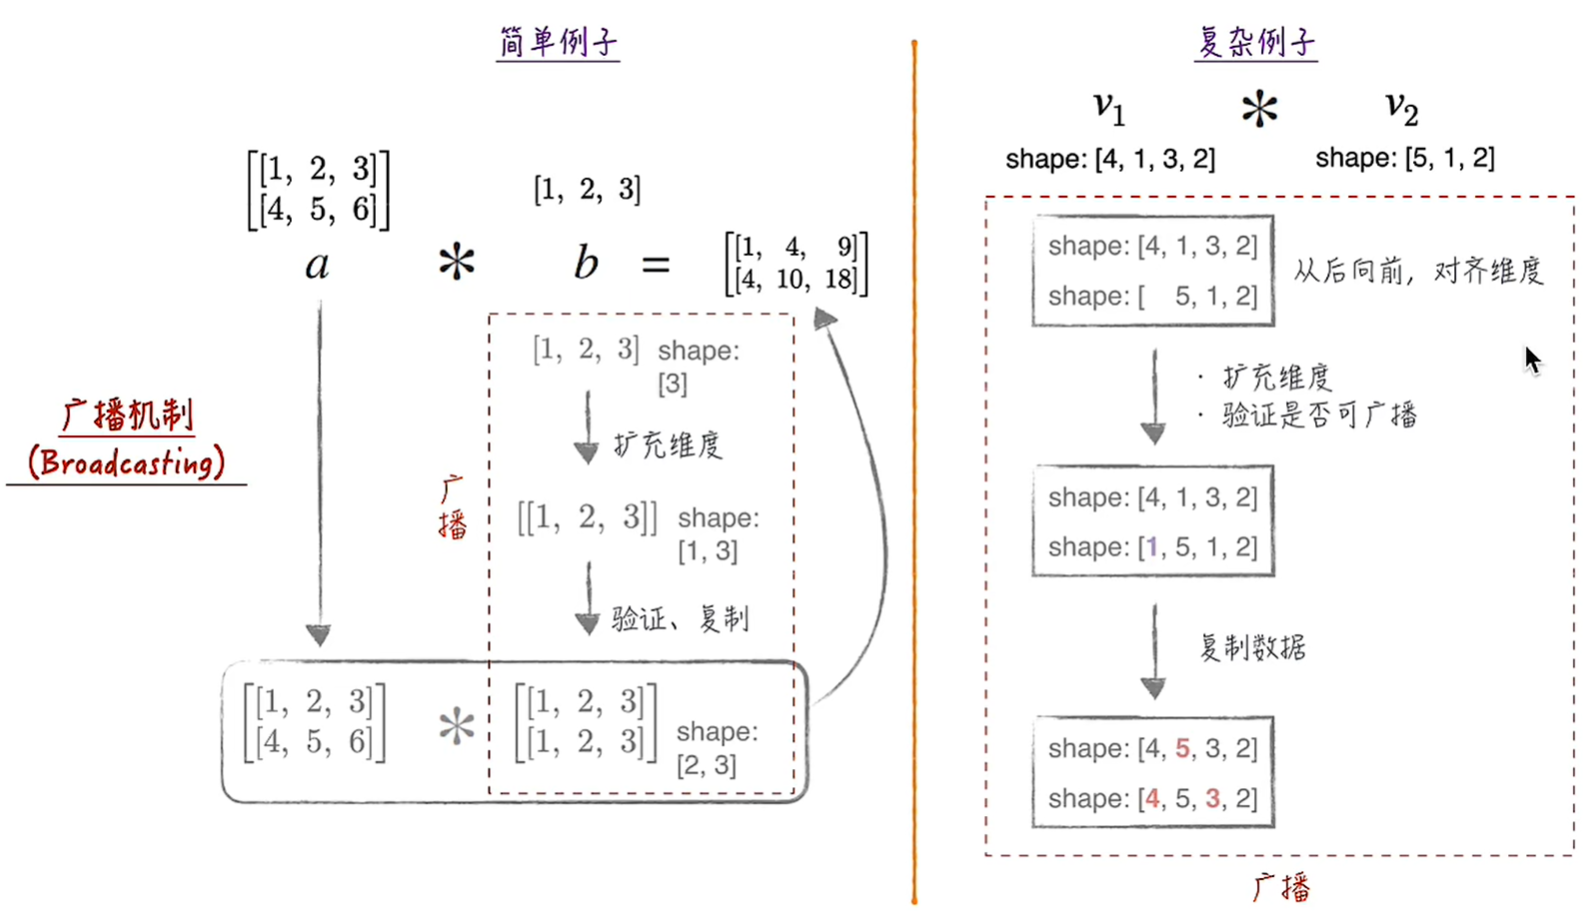

In [133]:
from IPython.display import Image

Image(filename='./images/Pytorch 广播机制.png')

In [135]:
### 矩阵运算
mat1 = torch.randn(3, 4)
mat2 = torch.randn(4, 5)

(mat1 @ mat2).shape

torch.Size([3, 5])

In [137]:
mat1 = torch.randn(5, 1, 3, 4)  # (5, 1, 3, 4)
mat2 = torch.randn(8, 4, 5)  # ( , 8, 4, 5)

(mat1 @ mat2).shape  # (5, 8, 3, 5)  后两位进行参考矩阵运算，前面因为广播机制填充

torch.Size([5, 8, 3, 5])